In [3]:
# import cell for our server:
from music21 import *
environment.keys()
environment.set('musicxmlPath', value='/usr/bin/musescore-xvfb')
environment.set('musescoreDirectPNGPath', value='/usr/bin/musescore-xvfb')

import numpy as np
import pylab
import random
from GTag import *

# Clustering For Keys
In the following notebook, we want to use Guttags KMC implementation (Chapter 23) to indentify keys of musical pieces. \
Note: 
- It is necessary to have the GTag.py file saved in the same folder as this notebook, or to adjust the code accordingly. GTag.py is a collection of classes and functions that Guttag introduces.
- We will use the same idea(s) as Guttag uses for the example to cluster for eating behaviors of animals, so it is helpful to understand it. 
- We will make use of the music21 library, which contains datastructures, functions and datasets for musical analsis. 

## Bag of Notes
A simple datastructure to analyze a musical piece is the bag-of-notes model. Simply put, we count the occurences of pitch classes in a piece of music. It is similar to the [bag-of-words model](https://en.wikipedia.org/wiki/Bag-of-words_model) 
### Example

In [4]:
# Loading a file from the music21 corpus
bach256 = corpus.parse('bwv256')
# Taking a look at the object we see that it is of the 'stream' datatype 
print(bach256)

<music21.stream.Score 0x7effa5af22d0>


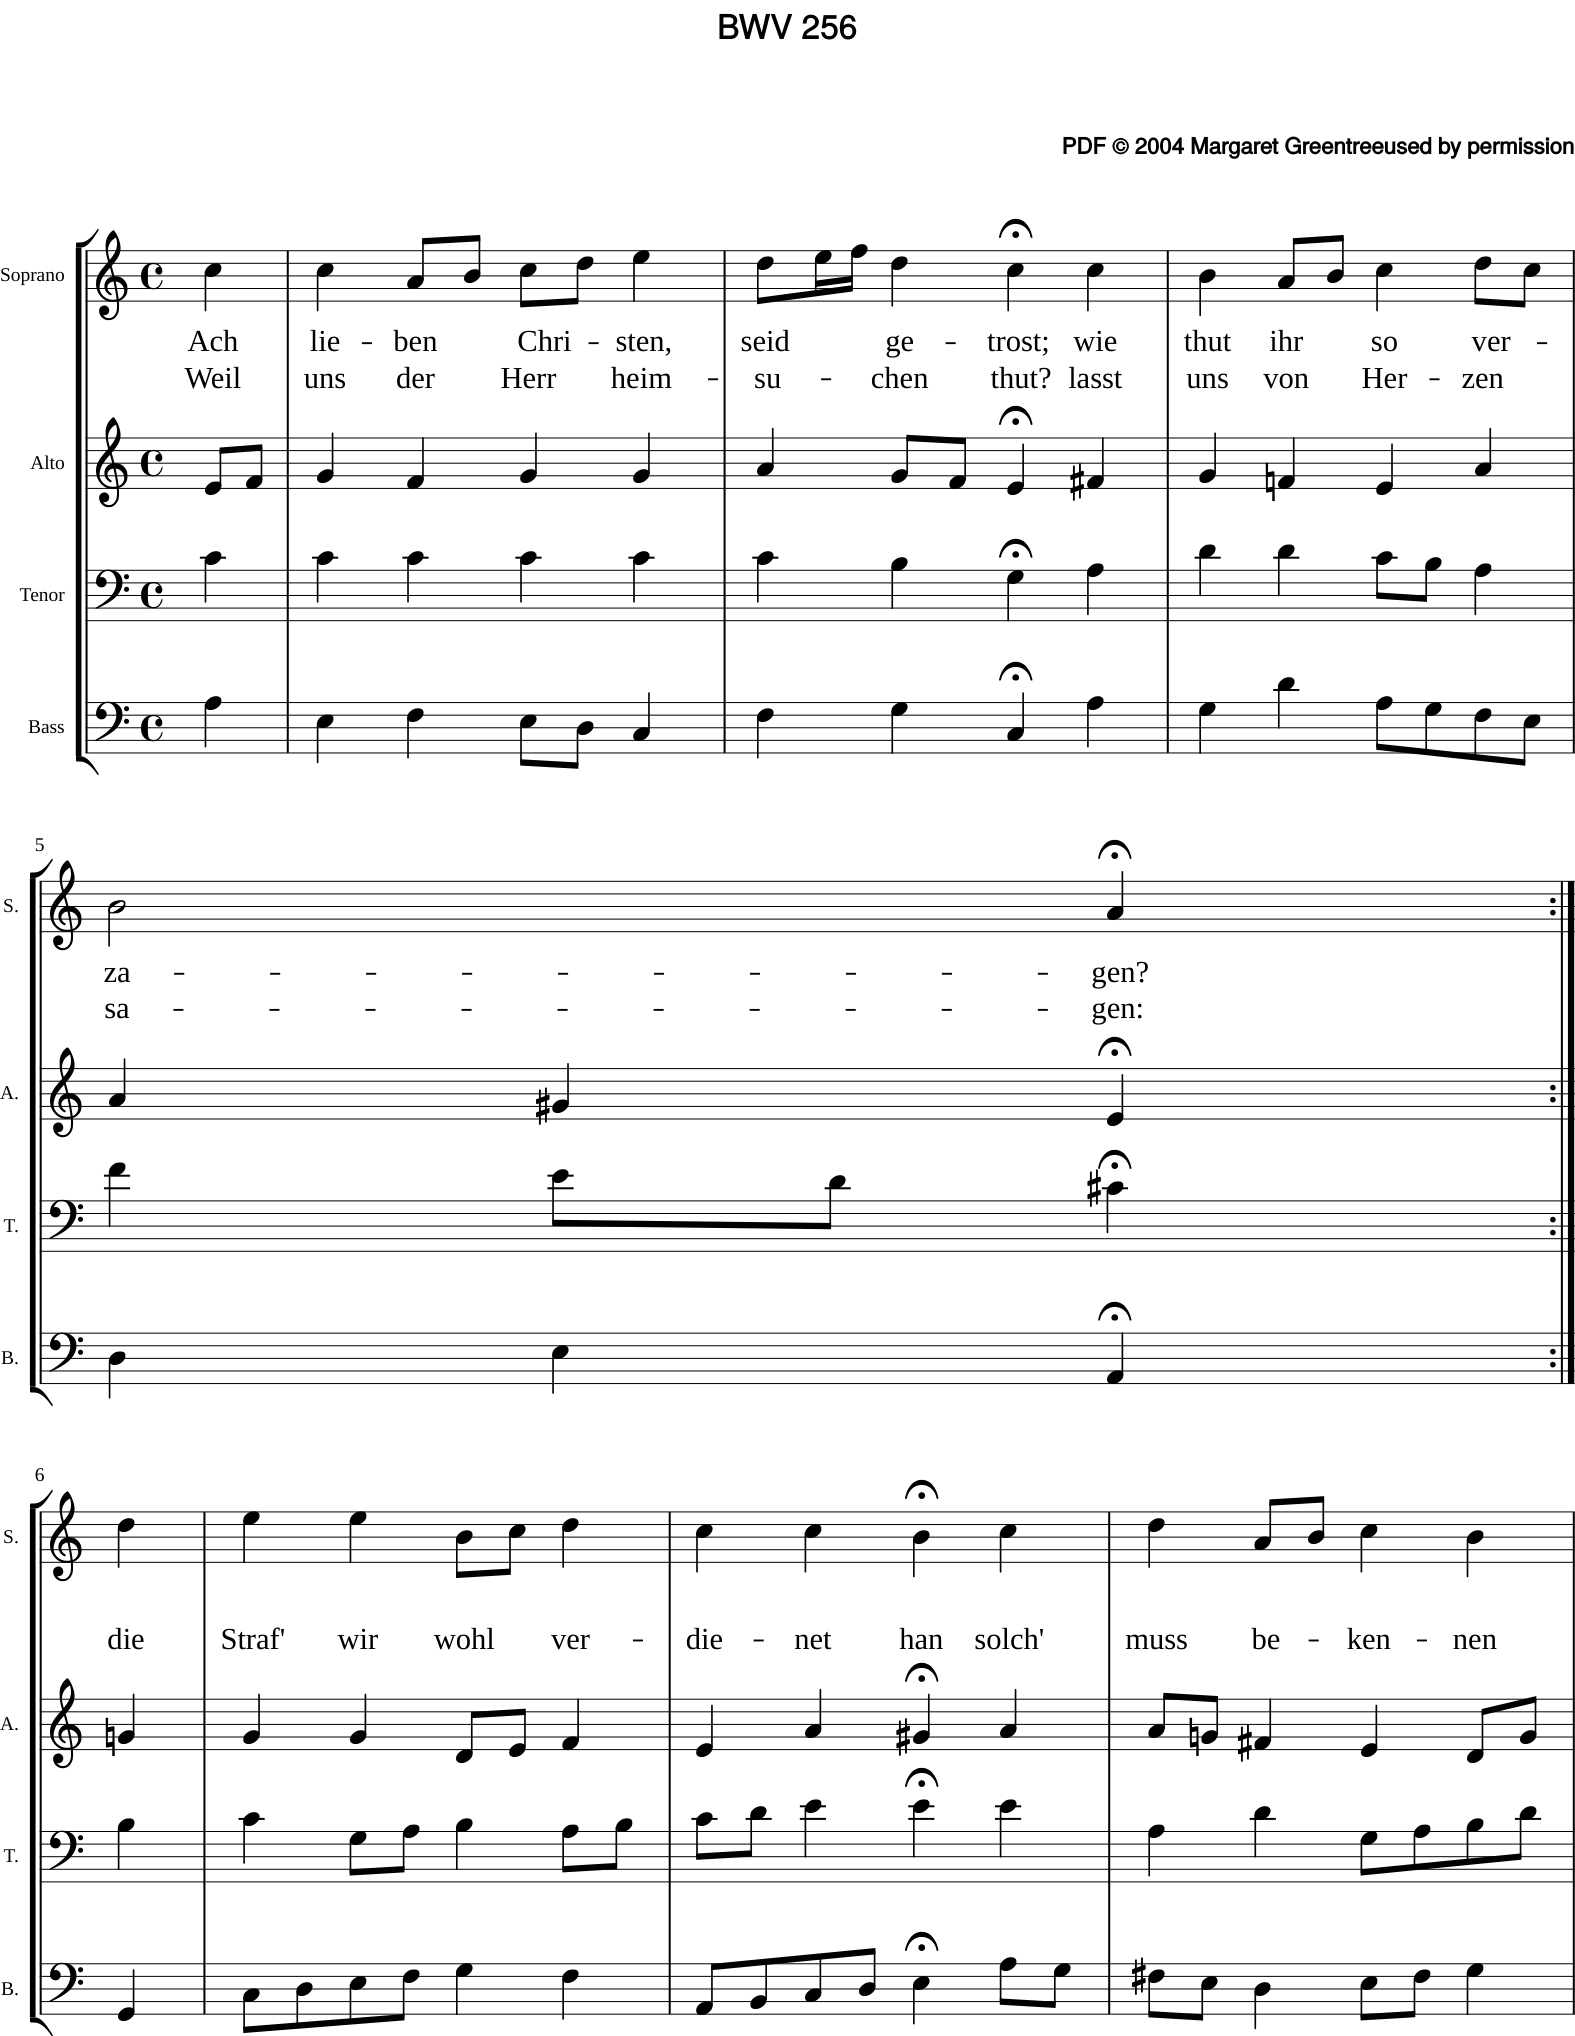

In [5]:
# Using its .show() function we see that it contains a lot of information
bach256.show()

In [6]:
len(bach256)

9

All the information (and more) in the above output can be extracted accessed through bach255 stream object. We are only interested in the pitchclasses. Since they are stored in a hierarchical (list-of-lists-like) manner, we cannot access them via simple iteration. We'll an inbuilt recursive function to solve this problem. See [here](https://web.mit.edu/music21/doc/usersGuide/usersGuide_05_listsOfLists.html) and [here](https://web.mit.edu/music21/doc/usersGuide/usersGuide_06_stream2.html) for further explanation. \
Now we'll define a function to preprocess a music21 stream for the KMC algorithm.

In [7]:
def bagNotes(currentPiece):
    pClasses = [0]*12 # 12 long vector of zeros for the pitch classe
    for currentNote in currentPiece.recurse().getElementsByClass(note.Note): # see below
        pClasses[currentNote.pitch.pitchClass] += 1 # raise the value for the pitch class by one 
    return pClasses

#### currentPiece.recurse().getElementByClass(note.Note)
- we feed the function a stream object
- recurse() allows us to iterate through its hierarchical structure
- getElementsByClass() filters the contained elements for objects of type note
- note objects contain a numerical value according to their pitch class, we can access via note.pitch.pitchClass

In [8]:
# example
bachClasses = bagNotes(bach256)
print(bachClasses)

[34, 2, 29, 0, 33, 15, 8, 26, 4, 32, 0, 24]


Note:
- We are technically not done yet, as we need to transfer the bag of notes into feature/label/name, to stay in line with the Guttag implementation.
- The model with only 12 pitch classes is simplified, as we don't take into account obvious thi 

## KMC
Again, the preprocessing is technically not needed for KMC, but for an easier understanding, we want to use the Guttag implementation and need lists of features, labels and names. 

### 'Read' Data
We now want to test the KMC on several pieces by Bach.

In [50]:
# loading the data, check the 
bachPaths = corpus.getComposer('bach') # lad file paths to all available pieces by Bach
bach_streams = []
for i in range(200): # parse 200 pieces into bachList, they get stored as stream objects
    bach_streams.append(corpus.parse(bachPaths[i]))

The following preprocessing is split into three functions for ease of understanding and could obviously rolled up into one funtion that returns all three lists needed as input for buildExamples()
### Features
Generate a bag of notes for each musical piece and put them all into a feature list. 

In [51]:
def buildFeatures(m21streamList): 
    features = [[]]*len(m21streamList) # empty list with entry for each stream in the list
    for i in range(len(m21streamList)): # iterate list of streams
        features[i] = bagNotes(m21streamList[i]) # apply bagNotes on each stream/piece
    return features

### Labels
Music21 streams have a built in [function](https://web.mit.edu/music21/doc/moduleReference/moduleStream.html#music21.stream.Stream.analyze) to check the key of a piece. We will use it to generate the labels for each piece.

In [52]:
# stuff we need to generate the labels
allKeys = {'A': 0,'A#': 1,'B-': 1,'B': 2,'C-': 2,'B#': 3,'C': 3,'C#': 4,'D-': 4, \
           'D': 5,'D#': 6,'E-': 6,'E': 7,'F-': 7,'E#': 8,'F': 8,'F#': 9,'G-': 9, \
           'G':10,'G#':11,'A-':11, \
           'a':12,'a#':13,'b-':13,'b':14,'c-':14,'b#':15,'c':15,'c#':16,'d-':16, \
           'd':17,'d#':18,'e-':18,'e':19,'f-':19,'e#':20,'f':20,'f#':21,'g-':21, \
           'g':22,'g#':23,'a-':23}

aKList = ['A','A#','B-','B','C-','B#','C','C#','D-', \
          'D','D#','E-','E','F-','E#','F','F#','G-', \
          'G','G#','A', \
          'a','a#','b-','b','c-','b#','c','c#','d-',  
          'd','d#','e-','e','f-','e#','f','f#','g-', \
          'g','g#','a-']

In [53]:
def buildLabels(m21streamList):  
    labels = [0]*len(m21streamList)
    for i in range(len(m21streamList)): 
        labels[i] = allKeys[m21streamList[i].analyze('key').tonicPitchNameWithCase] # .analyze each piece
    return labels

### Names
Streams also can also store their title in their [metadata object](https://web.mit.edu/music21/doc/moduleReference/moduleStream.html#music21.stream.Stream.metadata).

In [54]:
def buildNames(m21streamList):
    names = [0]*len(m21streamList)
    for i in range(len(m21streamList)):
        names[i] = m21streamList[i].metadata.title
        
    return names

### Examples
Despite its name, the buildMammalsExamples() function is actually universally applicable to build a list of Example() objects from lists of features, labels and names. 

In [55]:
def buildMammalExamples(featureList, labelList, speciesNames):
    examples = []
    for i in range(len(speciesNames)):
        features = pylab.array(featureList[i])
        example = Example(speciesNames[i], features, labelList[i])
        examples.append(example)
    return examples

### Putting it together

In [58]:
# Call the above functions
bach_features = buildFeatures(bach_streams)
bach_labels = buildLabels(bach_streams)
bach_names = buildNames(bach_streams)

In [59]:
bach_examples = buildMammalExamples(bach_features, bach_labels, bach_names)
# test
# featres, label and name are attributes of the example object, defined by Guttag
print(bach_examples[0].features)
print(bach_examples[0].label)
print(bach_examples[0].name)
print('-----')
print(bach_examples[1].features)
print(bach_examples[1].label)
print(bach_examples[1].name)
print('-----')
print(bach_examples[2].features)
print(bach_examples[2].label)
print(bach_examples[2].name)

[111   0  40   0  33 121   0  60   0  88  38   7]
8
bwv1.6.mxl
-----
[41  0 39 13  1 28  5 32  0 19 30  4]
22
bwv10.7.mxl
-----
[20  7 38  0 23 26  4 24  3 43 14  6]
17
bwv101.7.mxl


### Clustering
Guttags testteeth() is obviously not applicable. We just call teskmeans and define a proper output function for our data.

In [60]:
# Call
bach_clustering = trykmeans(bach_examples, 15, 30)

For our task the most interesting information about the clusters is realted to the labels of their members.
- Who is in the cluster? -> labelLst
- What unique kinds of labels are in the cluster? -> uniqueLbl
- How often to the unique labels occur? -> numberOfLbl
- What is the most occuring label? -> maxLbl

In [61]:
def whichClst(cluster):
    
    labelLst = []
    for currentExample in cluster.members(): 
        label = aKList[currentExample.getLabel()]
        labelLst.append(label)
    uniqueLbl = list(set(labelLst)) # filters for unique elements in the list
    maxLbl = uniqueLbl[0]
    numberOfLbl = [0]*len(uniqueLbl)
    index = 0
    for uLbl in uniqueLbl:
        numberOfLbl[index] = labelLst.count(uLbl) # counts the specified element in the list
        index += 1
        if labelLst.count(uLbl)>labelLst.count(maxLbl):
            maxLbl = uLbl
            
    return maxLbl,labelLst, uniqueLbl, numberOfLbl

In [62]:
# Output
def outputMsc(clusterLst):
    # the members() function allows us to iterate through a cluster. 
    # Each example object in the cluster will be called.
    # Remember that an example object has the following attributes: features, label, name     
    for clust in clusterLst:
        maxLbl,labelLst,uniqueLbl,numberOfLbl = whichClst(clust)
        print('')
        print('The cluster contains: ')
        print(labelLst)
        print('The following keys occur: ')
        print(uniqueLbl)
        print('The numbers of occurences are: ')
        print(numberOfLbl)
        print('The most occuring Label is: ')
        print(maxLbl)
        print('------------------------------------------------')  

In [63]:
outputMsc(bach_clustering)


The cluster contains: 
['B#', 'B#', 'B#', 'B#']
The following keys occur: 
['B#']
The numbers of occurences are: 
[4]
The most occuring Label is: 
B#
------------------------------------------------

The cluster contains: 
['D#', 'D#', 'D#', 'D#', 'D#', 'D#', 'D#', 'D#', 'D#', 'D#', 'D#', 'D#']
The following keys occur: 
['D#']
The numbers of occurences are: 
[12]
The most occuring Label is: 
D#
------------------------------------------------

The cluster contains: 
['B', 'B', 'D#', 'B', 'D#']
The following keys occur: 
['D#', 'B']
The numbers of occurences are: 
[2, 3]
The most occuring Label is: 
B
------------------------------------------------

The cluster contains: 
['E#', 'G#', 'G#', 'G#', 'G#', 'G#', 'G#', 'D#', 'G#', 'G#', 'G#', 'G#', 'G#']
The following keys occur: 
['D#', 'G#', 'E#']
The numbers of occurences are: 
[1, 11, 1]
The most occuring Label is: 
G#
------------------------------------------------

The cluster contains: 
['A', 'A', 'C#', 'C#', 'a', 'a', 'A', 'A', '

### Modifcations

Normalizing each bag, to prevent extreme outliers from dominating during clustering. Guttags zScaleFeatures() or iScaleFatures() could also be used.

In [64]:
def normList(l):
    return [element/sum(l) for element in l]

In [65]:
def buildFeaturesNrm(m21stream):
    features = [[]]*len(m21stream)
    for i in range(len(m21stream)):
        features[i] = normList(bagNotes(m21stream[i]))
    return features

We can also try a simple modification of the bag of notes model. In music21 every note object has a duration attribute, which we want to sum up for each class. \

In [66]:
def bagNotesDr(currentPiece): # bag notes duration
    pClasses = [0]*12 # 12 long vector of zeros for the pitch classe
    for currentNote in currentPiece.recurse().getElementsByClass(note.Note): # see below
        pClasses[currentNote.pitch.pitchClass] += currentNote.quarterLength  # sum up the durations.
    return pClasses

In [67]:
def buildFeaturesNrmDr(m21streamList):
    features = [[]]*len(m21streamList)
    for i in range(len(m21streamList)):
        features[i] = normList(bagNotesDr(m21streamList[i]))
    return features

In [68]:
# example
print('Bag of notes')
print(bachClasses)
print(normList(bachClasses))

# bag of length
bachClassesDr = bagNotesDr(bach256)
print('Bag of summed durations')
print(bachClassesDr)
print(normList(bachClassesDr))

Bag of notes
[34, 2, 29, 0, 33, 15, 8, 26, 4, 32, 0, 24]
[0.1642512077294686, 0.00966183574879227, 0.14009661835748793, 0.0, 0.15942028985507245, 0.07246376811594203, 0.03864734299516908, 0.12560386473429952, 0.01932367149758454, 0.15458937198067632, 0.0, 0.11594202898550725]
Bag of summed durations
[27.5, 2.0, 21.0, 0, 25.75, 10.75, 5.5, 21.0, 3.5, 24.25, 0, 18.75]
[0.171875, 0.0125, 0.13125, 0.0, 0.1609375, 0.0671875, 0.034375, 0.13125, 0.021875, 0.1515625, 0.0, 0.1171875]


In [70]:
bach_featuresNrm = buildFeaturesNrm(bach_streams)
bach_examplesNrm = buildMammalExamples(bach_featuresNrm, bach_labels, bach_names)
bach_clustering_Nrm = trykmeans(bach_examplesNrm, 15, 30)

bach_featuresNrmDr = buildFeaturesNrmDr(bach_streams)
bach_examplesNrmDr = buildMammalExamples(bach_featuresNrmDr, bach_labels, bach_names)
bach_clustering_NrmDr = trykmeans(bach_examplesNrmDr, 15, 30)                                

In [71]:
outputMsc(bach_clustering_Nrm)


The cluster contains: 
['G-', 'G-', 'G-', 'G-', 'G-', 'G-', 'E', 'G-', 'G-', 'G-', 'G-', 'G-', 'G-']
The following keys occur: 
['G-', 'E']
The numbers of occurences are: 
[12, 1]
The most occuring Label is: 
G-
------------------------------------------------

The cluster contains: 
['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A']
The following keys occur: 
['A']
The numbers of occurences are: 
[14]
The most occuring Label is: 
A
------------------------------------------------

The cluster contains: 
['D#', 'D#', 'D#', 'D#', 'D#', 'D#', 'D#', 'D#', 'D#', 'D#', 'D#', 'D#', 'G#', 'D#']
The following keys occur: 
['D#', 'G#']
The numbers of occurences are: 
[13, 1]
The most occuring Label is: 
D#
------------------------------------------------

The cluster contains: 
['C#', 'C#', 'a', 'a', 'C#', 'C#', 'a', 'a']
The following keys occur: 
['C#', 'a']
The numbers of occurences are: 
[4, 4]
The most occuring Label is: 
C#
--------------------------------------------

In [72]:
outputMsc(bach_clustering_NrmDr)


The cluster contains: 
['G-', 'G-', 'G-', 'G-', 'G-', 'G-', 'E', 'G-', 'G-', 'G-', 'G-', 'G-', 'G-']
The following keys occur: 
['G-', 'E']
The numbers of occurences are: 
[12, 1]
The most occuring Label is: 
G-
------------------------------------------------

The cluster contains: 
['a', 'a', 'a', 'a']
The following keys occur: 
['a']
The numbers of occurences are: 
[4]
The most occuring Label is: 
a
------------------------------------------------

The cluster contains: 
['F', 'C', 'C', 'A', 'F', 'E-', 'F', 'C', 'C', 'F']
The following keys occur: 
['C', 'A', 'F', 'E-']
The numbers of occurences are: 
[4, 1, 4, 1]
The most occuring Label is: 
C
------------------------------------------------

The cluster contains: 
['E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E']
The following keys occur: 
['E']
The numbers of occurences are: 
[22]
The most occuring Label is: 
E
------------------------------------------------

The clus